# Experiments 🧪
This notebook contains experimetns for some of the modules of STELLAR (A Structured, Trustworthy, and Explainable LLM-Led Architecture for Reliable Customer Support)

# 1. Requirements 🛠️

In [ ]:
# Installation of Required Libraries
!pip install groq langchain chromadb sentence-transformers langchain-community langchain-huggingface rank_bm25 -U > /dev/null 2>&1


# Google Drive and Groq API Initialization
from google.colab import drive, userdata
from groq import Groq
drive.mount('/content/drive')
client = Groq(api_key=userdata.get('GROQ_API_KEY_2'))
STELLAR_path = "/content/drive/MyDrive/STELLAR"

# Essential Imports
import os
import json
import nltk
from math import ceil
from datetime import datetime
import time
import pytz
import requests
import uuid
import logging
from scipy.special import softmax
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm
import pandas as pd

# Library-specific Imports
from rank_bm25 import BM25Okapi
from langchain.schema.document import Document
from langchain.prompts import ChatPromptTemplate
from langchain.vectorstores.chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    AutoConfig,
    logging as transformers_logging
)

# Set Logging Configuration
logging.basicConfig(level=logging.INFO)
transformers_logging.set_verbosity_error()

# Preloading Resources
nltk.download('punkt')
nltk.download('punkt_tab')

# Model Configuration
MODEL = "llama-3.3-70b-versatile"


class Module:
    def __init__(self, model_name="llama-3.3-70b-versatile"):
        self.model_name = model_name

    def ask_model(self, question: str, model: str="llama-3.3-70b-versatile") -> str:
        """
        Queries the Groq API with a question and model.

        Args:
            question (str): The input question for the model.
            model (str): The model to query.

        Returns:
            str: The response from the model as a string or None if an error occurs.
        """
        try:
            response = client.chat.completions.create(
                messages=[{"role": "user", "content": question}],
                model=model,
            )
            return response.choices[0].message.content
        except Exception as e:
            try:
              client = Groq(api_key=userdata.get('GROQ_API_KEY_3'))
              response = client.chat.completions.create(
                  messages=[{"role": "user", "content": question}],
                  model=model,
              )
              return response.choices[0].message.content
            except Exception as e:
              try:
                client = Groq(api_key=userdata.get('GROQ_API_KEY_4'))
                response = client.chat.completions.create(
                    messages=[{"role": "user", "content": question}],
                    model=model,
                )
                return response.choices[0].message.content
              except Exception as e:
                try:
                  client = Groq(api_key=userdata.get('GROQ_API_KEY_2'))
                  response = client.chat.completions.create(
                      messages=[{"role": "user", "content": question}],
                      model=model,
                  )
                  return response.choices[0].message.content
                except Exception as e:
                  print(f"Error: {e}")
                  # Immediately stop execution
                  exit()
                  return None


    def load_txt_file(self, path):
        """
        Loads a text file from the specified path.

        Args:
            path (str): The path to the text file.

        Returns:
            str: The contents of the text file.
        """
        try:
            with open(path, 'r') as file:
                return file.read()
        except FileNotFoundError:
            print(f"File not found: {path}")
            return ""

    def load_json_file(self, path:str) -> dict:
        """
        Loads a JSON file from the specified path.

        Args:
            path (str): The path to the JSON file.

        Returns:
            dict: The contents of the JSON file as a dictionary.
        """
        try:
            with open(path, 'r') as file:
                return json.load(file)
        except FileNotFoundError:
            print(f"File not found: {path}")
            return {}

    def parse_str_to_json(self, string, required_fields):
        """
        Parses a string containing a JSON-like dictionary and verifies the required fields.

        Args:
            string (str): The string to parse, expected to contain a JSON-like dictionary.
            required_fields (list): The fields that the dictionary must contain.

        Returns:
            dict: The parsed dictionary if successful.

        Raises:
            ValueError: If the parsing fails or the dictionary does not contain the required fields.
        """
        try:
            # Extract the JSON-like content from the string
            json_start = string.find("{")
            json_end = string.find("}") + 1
            if json_start == -1 or json_end == -1:
                raise ValueError("No valid JSON content found in the string.")

            json_string = string[json_start:json_end]
            parsed_dict = json.loads(json_string)

            # Verify required fields
            if not all(field in parsed_dict for field in required_fields):
                raise ValueError(f"Missing required fields: {required_fields}")

            return parsed_dict

        except Exception as e:
            raise ValueError(f"Error parsing string to JSON: {e}")

    def get_current_date_time(self, timezone:str='America/Sao_Paulo') -> dict:
        """
        Gets the current date and time in the specified timezone.

        Args:
            timezone (str): The timezone to use.

        Returns:
            dict: A dictionary containing the current time, in the format:
              {"year": <int>, "month": <int>, "day": <int>, "hour": <int>}

        """
        timezone = pytz.timezone('America/Sao_Paulo')
        timezone_time = datetime.now(timezone)
        time = {
            "year": timezone_time.year,
            "month": timezone_time.month,
            "day": timezone_time.day,
            "hour": timezone_time.hour
        }

        return time

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# 2. Module 1 🤖

## 2.1 Module Definition

In [ ]:
class Module1_InitialClassifier(Module):
    def __init__(self, model_name:str=MODEL, prompt_path:str=f"{STELLAR_path}/requirements/module_1/prompt_module1.txt"):
        super().__init__(model_name)
        self.prompt_path = prompt_path


    def classify_question(self, question: str) -> dict:
        """
        Receives a question and returns the response in JSON format. Retries up to 3 times
        if the response is not correctly formatted. If still invalid, returns a default answer.

        Args:
            question (str): The question to send to the LLM.
            model (str): The model to query.

        Returns:
            dict: Validated response from the LLM or a default fallback answer. format:
            {"category": <int>, "answer": <str>, "explanation": <str>, "confidence": <float>}
        """
        # Get the prompt
        with open(self.prompt_path, "r") as f:
            prompt = f.read()

        # Add the question to the prompt
        full_prompt = prompt + question

        default_answer = {
            'category': 0,
            'answer': "ERROR.",
            'explanation': 'Default error message.',
            'confidence': 1
        }

        for attempt in range(3):
            response = self.ask_model(full_prompt, self.model_name)

            if response is None:
                print(f"Attempt {attempt + 1}: No response from model.")
                continue

            parsed_response = self.parse_str_to_json(response, ['category', 'answer', 'explanation', 'confidence'])
            if type(parsed_response["category"]) != int or parsed_response["category"] not in [0, 1, 2, 3]:
                print(f"Attempt {attempt + 1}: Invalid response format.")
                continue

            if parsed_response:
                return parsed_response
            else:
                print(f"Attempt {attempt + 1}: Response parsing failed.")

        print("All attempts failed. Returning default answer.")
        return default_answer

## 2.2 Running Experiment

In [ ]:
# Loading test cases
with open (f"{STELLAR_path}/experiments/test_cases/module_1.json", "r") as f:
    test_cases = json.load(f)

# Running Experiment
results = []
module = Module1_InitialClassifier()
for test_case in tqdm(test_cases, desc="Processing Test Cases"):
    try:
        module_answer = module.classify_question(test_case["question"])
        correct_category = test_case["category"]
        results.append({
            "question": test_case["question"],
            "module_answer": module_answer,
            "correct_category": correct_category
        })
    except KeyError as e:
            print(f"\nWarning: Test case missing expected key: {e}. Skipping item: {test_case}")
    except Exception as e:
            print(f"\nAn error occurred processing test case {test_case.get('id', 'N/A')}: {e}")

## 2.3 Displaying Results

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


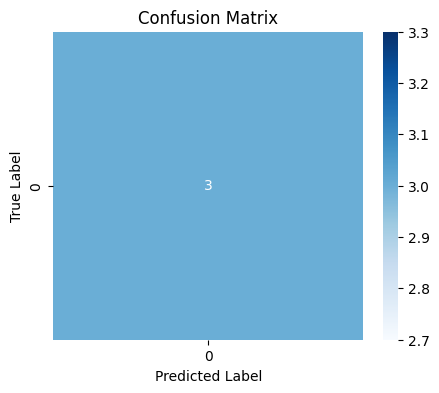

Accuracy: 100.00%

              precision  recall  f1-score  support
0                  1.00    1.00      1.00     3.00
accuracy           1.00    1.00      1.00     1.00
macro avg          1.00    1.00      1.00     3.00
weighted avg       1.00    1.00      1.00     3.00


In [ ]:
# Extract predictions and true labels
y_pred = [res["module_answer"]["category"] for res in results]
y_true = [int(res["correct_category"]) for res in results]

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)

# Compute F1-score for each class
classification_rep = classification_report(y_true, y_pred, output_dict=True)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_true), yticklabels=set(y_true))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Convert classification report to DataFrame
df_report = pd.DataFrame(classification_rep).transpose()

# Display formatted output
print(f"Accuracy: {accuracy:.2%}\n")
print(df_report.to_string(float_format="%.2f"))

In [ ]:
# Extract misclassified examples
misclassified = [
    {
        "question": res["question"],
        "correct_category": res["correct_category"],
        "predicted_category": res["module_answer"]["category"],
        "explanation": res["module_answer"].get("explanation", "No explanation provided")
    }
    for res in results if int(res["correct_category"]) != res["module_answer"]["category"]
]

# Display misclassified questions
if not misclassified:
    print("No misclassified questions found.")
else:
  print("\nMisclassified Questions:\n", end="")
  for example in misclassified:
      print()
      print(f"Question: {example['question']}")
      print(f"Correct Category: {example['correct_category']}")
      print(f"Predicted Category: {example['predicted_category']}")
      print(f"Explanation: {example['explanation']}")

No misclassified questions found.


# 3. Module 2 🤖

## 3.1 Module Definition

In [ ]:
class Module2_RAG(Module):
    def __init__(self, embedding_model: str, model_name=MODEL,
                 data_path: str = f"{STELLAR_path}/requirements/module_2/FAQs.json",
                 chroma_path: str = f"{STELLAR_path}/experiments/vector_databases",
                 prompt_template_path: str = f"{STELLAR_path}/requirements/module_2/prompt_template.txt",
                 prompt_rerank_path: str = f"{STELLAR_path}/requirements/module_2/prompt_rerank.txt",
                 n_retrieved_chunks: int = 10):
        super().__init__(model_name)
        self.data_path = data_path
        self.vector_database_path = f"{chroma_path}/{embedding_model}"
        self.prompt_template_path = prompt_template_path
        self.prompt_rerank_path = prompt_rerank_path
        self.embedding_model = embedding_model
        self.n_retrieved_chunks = n_retrieved_chunks

    def create_database(self):
        """
        Creates the Chroma database.
        """
        # If the database already exists, return
        path = f"{self.vector_database_path}"
        if os.path.exists(path):
          return
        # load the items from the .json file
        documents = self.load_documents()
        # Save the chunks to the chroma directory
        self.add_to_chroma(documents, model_name=self.embedding_model)

    def add_to_chroma(self, chunks: list[Document], model_name: str):
        """
        Adds the documents to the Chroma database.

        Args:
            chunks (list[Document]): The documents to add to the database in this format:
                {"id": <int>, "category": <str>, "question": <str>, "answer": <str>}
            model_name (str): The name of the embedding model to use.
        Returns:
            None
        """
        # Load the database
        path = f"{self.vector_database_path}"
        database = Chroma(
            persist_directory=path,
            embedding_function=self.get_embedding_function(model_name))
        # Add the chunks to the database
        existing_items = database.get(include=[]) # IDs are included by default
        existing_ids = set(existing_items["ids"])
        print(f"Number of existing items: {len(existing_ids)}.")
        # Filter out the chunks that are already in the database
        chunks_to_add = []
        for chunk in chunks:
            if chunk["id"] not in existing_ids:
                chunks_to_add.append(chunk)
        # Add the chunks to the database
        if len(chunks_to_add) > 0:
            print(f"Adding {len(chunks_to_add)} items to the database.")
            documents_to_add = []
            for chunk in chunks_to_add:
                # Create a Document object for each chunk
                document = Document(
                    page_content=chunk["question"] + "\n" + chunk["answer"],
                    metadata={
                        "id": chunk["id"],
                        "category": chunk["category"],
                        "question": chunk["question"],
                        "answer": chunk["answer"]})
                documents_to_add.append(document)
            # Add documents to the database
            database.add_documents(documents=documents_to_add)
            database.persist()
            print("✅ Database updated with new items.")
        else:
            print("✅ No new items to add.")

    def load_documents(self) -> list[Document]:
        """Loads the documents from the data directory.
        Documents are dictionaries with the fields:
        id, category, question, answer.

        Returns:
            list[Document]: A list of Document objects in this format:
            {"id": <int>, "category": <str>, "question": <str>, "answer": <str>}
        """
        with open(self.data_path, "r") as f:
          documents = json.load(f)
        return documents

    def get_embedding_function(self, embedding_model):
        """
        Gets the embedding function for the given embedding model.
        Args:
            embedding_model (str): The name of the embedding model.
        Returns:
            HuggingFaceEmbeddings: The embedding function.
        """
        model = f"sentence-transformers/{embedding_model}"
        model_kwargs = {"device": "cpu"}
        encode_kwargs = {"normalize_embeddings": True}
        embeddings = HuggingFaceEmbeddings(
            model_name=model,
            model_kwargs=model_kwargs,
            encode_kwargs=encode_kwargs
        )
        return embeddings

    def semantic_retrieval(self, question: str, n:int, model_name:str) -> list[int]:
        """Receives a question and retrieves n FAQ ids related to the question
        Args:
            question (str): The question to be answered.
            n (int): The number of FAQs to be retrieved.
        Return:
            a list of the ids of the n FAQs related to the question
        """
        # Prepare the database.
        embedding_function = self.get_embedding_function(self.embedding_model)
        path = f"{self.vector_database_path}"
        database = Chroma(persist_directory=path, embedding_function=embedding_function)

        # Search the database (results:List[Tuple[Document, float]]).
        results = database.similarity_search_with_score(question, k=n)

        # Return only the ids
        for i in range(len(results)):
            results[i] = results[i][0].metadata["id"]

        return results

    def BM25_retrieval(self, question: str, n: int, list_of_chunks: list[str]) -> list[int]:
        """
        Retrieve top-n chunks using BM25 based on the given question.
        Args:
            question (str): The query question.
            n (int): Number of chunks to retrieve.
            list_of_chunks (List[str]): The list of chunks to search within.
        Returns:
            List[int]: ids of the selected chunks
        """
        # Tokenize the chunks and the question
        tokenized_chunks = [nltk.word_tokenize(chunk) for chunk in list_of_chunks]
        tokenized_question = nltk.word_tokenize(question)

        # Initialize the BM25 model
        bm25 = BM25Okapi(tokenized_chunks)

        # Score the chunks based on the question
        scores = bm25.get_scores(tokenized_question)

        # Get the indices of the top-n chunks based on scores
        top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:n]

        return top_indices


    def hybrid_search(self, question: str, n: int, embedding_model: str) -> list[int]:
      """Receives a question and retrieves n FAQs related to the question
      Return: a list of the ids of the n FAQs related to the question
      """
      # 70% Semantic search (round up)
      n_semantic = ceil(0.7 * n)
      semantic_ids = self.semantic_retrieval(question, n_semantic, embedding_model)


      # 30% BM25 search
      n_bm25 = n - n_semantic

      # Search for n chunks so that we can choose the 30% most similar that are not in semantic_ids
      with open (self.data_path, 'r') as file:
        data = json.load(file)
      # Use the "question only" approach by default
      chunks = [data[i]["question"] for i in range(len(data))]
      bm25_ids = self.BM25_retrieval(question, n, chunks)
      # Choose the 30% most similar that are not in semantic_ids
      bm25_ids = [i for i in bm25_ids if i not in semantic_ids]
      bm25_ids = bm25_ids[:n_bm25]

      hybrid_ids = semantic_ids + bm25_ids
      return hybrid_ids

    def error_handler(self, faq_ids: list[int], reranked_ids: list[int]) -> list[int]:
        """
        Adjusts a reranked list of IDs to match the FAQ IDs list in length and content.

        Args:
            faq_ids (List[int]): The original list of FAQ IDs.
            reranked_ids (List[int]): The reranked list of IDs.

        Returns:
            List[int]: A list with the correct number of unique IDs matching FAQ IDs.

        Raises:
            Exception: If reranked_ids is not a list.
        """

        # Validate input type
        if not isinstance(reranked_ids, list):
            raise Exception("The reranked_ids variable is not a list")

        # Ensure reranked_ids contains only unique integers
        reranked_ids = [rr_id for rr_id in reranked_ids if isinstance(rr_id, int)]
        reranked_ids = list(dict.fromkeys(reranked_ids))  # Remove duplicates

        # Case 1: If sizes match, return as-is
        if len(reranked_ids) == len(faq_ids):
            return reranked_ids

        # Case 2: If reranked_ids is smaller, fill missing IDs from faq_ids
        if len(reranked_ids) < len(faq_ids):
            missing_ids = [faq_id for faq_id in faq_ids if faq_id not in reranked_ids]
            return reranked_ids + missing_ids[:len(faq_ids) - len(reranked_ids)]

        # Case 3: If reranked_ids is larger, filter out extras and recurse
        reranked_ids = [rr_id for rr_id in reranked_ids if rr_id in faq_ids]
        return self.error_handler(faq_ids, reranked_ids)


    def groq_LLM_reranking(self, query: str, faq_ids: list[int], model: str, answers:bool = True) -> list[str]:
        """
        Reranks a list of FAQs based on their relevance to the query using Groq API.

        Args:
            query (str): The question from the customer.
            faq_ids (List[int]): A list of the ids of the FAQs returned after a dense retrieval.
            model (str): The model to use for reranking.

        Returns:
            List[int]: The same FAQ ids reranked by relevance.
        """
        def load_faqs(self, faq_ids: list[int]) -> list[tuple]:
            """Loads FAQs matching the given IDs from the data file.
            Retuns:
                List[Tuple[str, str, int]]
            """
            with open(self.data_path, 'r') as file:
                data = json.load(file)
            return [(faq["question"], faq["answer"], faq["id"]) for faq in data if faq["id"] in faq_ids]
        def build_prompt(self, query: str, faqs_with_ids: list[tuple], answers:bool = False) -> str:
            """Constructs the prompt for the model."""
            with open(self.prompt_rerank_path, 'r') as file:
                prompt = file.read()
            if not answers:
              related_questions = "\n".join(f"{faq_id}: {content}" for content, answer, faq_id in faqs_with_ids)
              return f"{prompt}\nDúvida do cliente:\n{query}\nPerguntas relacionadas:\n{related_questions}\n\nSaída:"
            else:
              related_questions = "\n".join(f"{faq_id}: {content}\n{answer}" for content, answer, faq_id in faqs_with_ids)
              return f"{prompt}\nDúvida do cliente:\n{query}\nPerguntas relacionadas:\n{related_questions}\n\nSaída:"
        def parse_model_response(self, response: str) -> list[int]:
            """Parses the model's response into a list of IDs."""
            start = response.find("[")
            end = response.find("]") + 1
            return json.loads(response[start:end])
        def call_model_with_retries(self, prompt: str, max_retries: int = 3) -> list[int]:
            """Attempts to call the model with retries in case of failure."""
            for attempt in range(max_retries):
                try:
                    response = self.ask_model(prompt, model)
                    reranked_ids = parse_model_response(self, response)
                    reranked_ids = self.error_handler(faq_ids, reranked_ids)

                    if isinstance(reranked_ids, list) and len(reranked_ids) == len(faq_ids):
                        return reranked_ids
                    else:
                        raise ValueError("Invalid response format or length mismatch.")

                except Exception as e:
                    print(f"Attempt {attempt + 1} failed: {e}")

            # Fall back to the original FAQ order if all retries fail
            print("Model inference failed after all retries.")
            return faq_ids
        # Main process
        with open(self.prompt_rerank_path, 'r') as file:
            prompt = file.read()
        try:
            faqs_with_ids = load_faqs(self, faq_ids)
            prompt = build_prompt(self, query=query, faqs_with_ids=faqs_with_ids)
            return call_model_with_retries(self, prompt)
        except Exception as e:
            print("Unexpected error:", e)
            return faq_ids

    def query_model(self, question: str, FAQ_ids, n_ids):
        """
        Queries the LLM with the retrieved FAQS to generate the answer to the client.
        Args:
            question (str): The question from the customer.
            FAQ_ids (List[int]): A list of the ids of the FAQs returned after a hybrid retrieval.
            n_ids (int): The number of FAQs to be retrieved.

        Returns:
            str: The answer to the question.
        """
        # Use the n_ids chunks with the highest similarity
        FAQ_ids = FAQ_ids[:n_ids]

        # create the context
        with open (self.data_path, 'r') as file:
            data = json.load(file)
        chunks = []
        for id in FAQ_ids:
          for faq in data:
            if faq["id"] == id:
              chunks.append(faq["question"]+"\n"+faq["answer"])
              break

        context_text = "\n---\n".join([chunk for chunk in chunks])
        # Apply the prompt template to the query
        with open(self.prompt_template_path, 'r') as file:
            PROMPT_TEMPLATE = file.read()
        prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
        prompt = prompt_template.format(context=context_text, question=question)

        model_answer = self.ask_model(prompt, self.model_name)

        # Format the response
        sources = FAQ_ids
        formatted_response = f"\033[34mAnswer: {model_answer}\033[0m\n\033[32mSources (FAQ ids): {sources}\033[0m"
        return formatted_response

    # Main function to handle the entire RAG process
    def process_question(self, question: str, n_ids: int = 5)->str:
        """
        Retrieves FAQs from the database, reranks these FAQs
        and answers the question based on them.

        Args:
            question (str): The question to be answered.
            n_ids (int): The number of FAQs to be retrieved.

        Returns:
            str: The answer to the question.
        """
        # Step 1: Retrieve IDs from the database
        retrieved_ids = self.hybrid_search(question, self.n_retrieved_chunks, self.embedding_model)

        # Step 2: Re-rank the retrieved IDs
        reranked_ids = self.groq_LLM_reranking(
            question,
            retrieved_ids,
            self.model_name,
            answers=True
        )

        # Step 3: Query the model with the top `n_ids` chunks
        formatted_response = self.query_model(question, reranked_ids, n_ids)
        return formatted_response

## 3.2 Running Experiment

### 3.2.1 Semantic Search Experiment

In [ ]:
# Define experiment parameters
embedding_models = ["all-MiniLM-L6-v2", "all-mpnet-base-v2", "multi-qa-MiniLM-L6-cos-v1", "all-MiniLM-L12-v2"]
n_values = list(range(1, 11))  # n from 1 to 10

# Loading test cases
with open(f"{STELLAR_path}/experiments/test_cases/module_2.json", "r") as f:
    test_cases = json.load(f)

# Function to evaluate a single query
def evaluate_query(retrieved_ids, correct_ids, start_time, end_time):
    rr = next((1 / (i + 1) for i, id in enumerate(retrieved_ids) if id in correct_ids), 0)
    hit_rates = [int(any(id in correct_ids for id in retrieved_ids[:n])) for n in range(1, 11)]
    recalls = [len(set(retrieved_ids[:n]) & correct_ids) / len(correct_ids) for n in range(1, 11)]
    recall_5 = len(set(retrieved_ids[:5]) & correct_ids) / len(correct_ids)
    delay = end_time - start_time
    return rr, hit_rates, recalls, delay

# Run experiments
results_ss = {}
hit_rates_per_model = {model: [] for model in embedding_models}
for model in tqdm(embedding_models, desc="Evaluating models"):
    module = Module2_RAG(embedding_model=model)
    all_rr, all_hit_rate_5, all_recall_5, all_delays = [], [], [], []

    for test_case in tqdm(test_cases, desc=f"Processing {model}", leave=False):
        start_time = time.time()
        retrieved_ids = module.semantic_retrieval(test_case["question"], 10, model)
        end_time = time.time()

        rr, hit_rates, recalls, delay = evaluate_query(retrieved_ids, set(test_case["correct_FAQs_ids"]), start_time, end_time)
        all_rr.append(rr)
        all_hit_rate_5.append(hit_rates[4])  # Hit-Rate@5
        all_recall_5.append(recalls[4])  # Recall@5
        all_delays.append(delay)
        hit_rates_per_model[model].append(hit_rates)

    results_ss[model] = {
        "MRR": np.mean(all_rr),
        "Hit-Rate@5": np.mean(all_hit_rate_5),
        "Recall@5": np.mean(all_recall_5),
        "Average Metrics": np.mean([np.mean(all_rr), np.mean(all_hit_rate_5), np.mean(all_recall_5)]),
        "Avg Delay": np.mean(all_delays)
    }


Evaluating models:   0%|          | 0/4 [00:00<?, ?it/s]

Processing all-MiniLM-L6-v2:   0%|          | 0/100 [00:00<?, ?it/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<ipython-input-8-8ae6c2b7d22e>:117: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  database = Chroma(persist_directory=path, embedding_function=embedding_function)


Processing all-mpnet-base-v2:   0%|          | 0/100 [00:00<?, ?it/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Processing multi-qa-MiniLM-L6-cos-v1:   0%|          | 0/100 [00:00<?, ?it/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Processing all-MiniLM-L12-v2:   0%|          | 0/100 [00:00<?, ?it/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### 3.2.2 Hybrid Search and Reranking

In [ ]:
# Define experiment approaches
approaches = [
    "Semantic Search without reranking",
    "Semantic Search with reranking",
    "Hybrid Search without reranking",
    "Hybrid Search with reranking"
]

# Load test cases
with open(f"{STELLAR_path}/experiments/test_cases/agent_2.json", "r") as f:
    test_cases = json.load(f)

# Function to evaluate a single query
def evaluate_query(retrieved_ids, correct_ids, start_time, end_time):
    rr = next((1 / (i + 1) for i, id in enumerate(retrieved_ids) if id in correct_ids), 0)
    hit_rate_5 = int(any(id in correct_ids for id in retrieved_ids[:5]))
    recall_5 = len(set(retrieved_ids[:5]) & correct_ids) / len(correct_ids)
    delay = end_time - start_time
    return rr, hit_rate_5, recall_5, delay

# Initialize results_per_approach
results_per_approach = {approach: {"MRR": [], "Hit-Rate@5": [], "Recall@5": [], "Delays": []} for approach in approaches}
agent = Agent2_RAG(embedding_model="all-MiniLM-L6-v2")

# Run experiments
for test_case in tqdm(test_cases, desc="Evaluating different approaches"):
    question = test_case["question"]
    correct_ids = set(test_case["correct_FAQs_ids"])

    def run_eval(retrieve_fn, approach_idx, *args):
        start = time.time()
        ids = retrieve_fn(question, *args)
        end = time.time()
        rr, hit, recall, delay = evaluate_query(ids, correct_ids, start, end)
        for k, v in zip(["MRR", "Hit-Rate@5", "Recall@5", "Delays"], [rr, hit, recall, delay]):
            results_per_approach[approaches[approach_idx]][k].append(v)
        return ids

    retrieved_ids = run_eval(agent.semantic_retrieval, 0, 10, "all-MiniLM-L6-v2")
    run_eval(agent.groq_LLM_reranking, 1, retrieved_ids, MODEL)
    hybrid_ids = run_eval(agent.hybrid_search, 2, 10, "all-MiniLM-L6-v2")
    run_eval(agent.groq_LLM_reranking, 3, hybrid_ids, MODEL)


# Compute final results_per_approach
final_results_per_approach = {}
for approach in approaches:
    final_results_per_approach[approach] = {
        "MRR": np.mean(results_per_approach[approach]["MRR"]),
        "Hit-Rate@5": np.mean(results_per_approach[approach]["Hit-Rate@5"]),
        "Recall@5": np.mean(results_per_approach[approach]["Recall@5"]),
        "Average Metric": np.mean([
            np.mean(results_per_approach[approach]["MRR"]),
            np.mean(results_per_approach[approach]["Hit-Rate@5"]),
            np.mean(results_per_approach[approach]["Recall@5"])
        ]),
        "Avg Delay": np.mean(results_per_approach[approach]["Delays"])
    }

Evaluating different approaches:   0%|          | 0/100 [00:00<?, ?it/s]

## 3.3 Displaying Results

### 3.3.1 Semantic Search results

In [ ]:
results_df = pd.DataFrame(results_ss).T
results_df

,MRR,Hit-Rate@5,Recall@5,Average Metrics,Avg Delay
all-MiniLM-L6-v2,0.896762,0.98,0.970000,0.948921,3.361582
all-mpnet-base-v2,0.899429,0.97,0.960000,0.943143,3.170146
multi-qa-MiniLM-L6-cos-v1,0.868190,0.96,0.941667,0.923286,2.890906
all-MiniLM-L12-v2,0.898417,0.97,0.955000,0.941139,2.975486


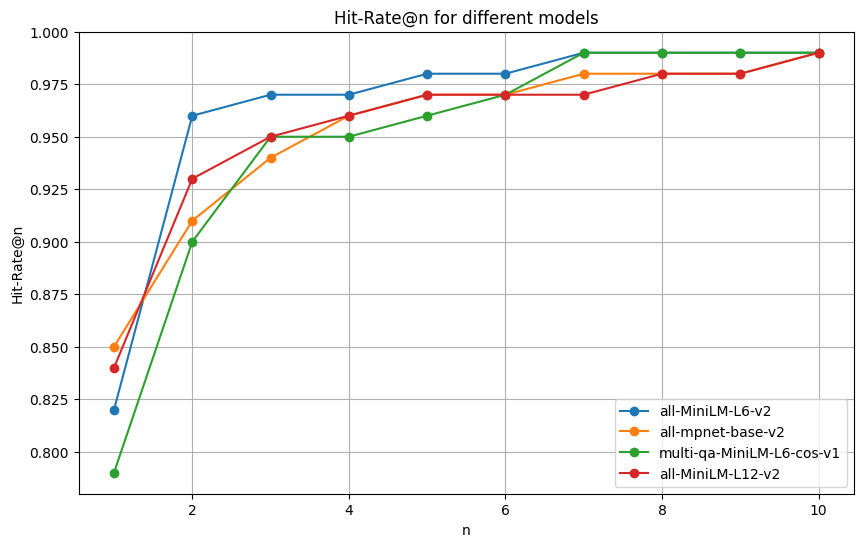

In [ ]:
# Plot Hit-Rate@n
plt.figure(figsize=(10, 6))
for model in embedding_models:
    avg_hit_rates = np.mean(hit_rates_per_model[model], axis=0)
    plt.plot(n_values, avg_hit_rates, marker='o', label=model)

plt.xlabel("n")
plt.ylabel("Hit-Rate@n")
plt.title("Hit-Rate@n for different models")
plt.legend()
plt.grid()
plt.show()

### 3.3.2 Hybrid Search and Reranking Results

In [ ]:
# Display results_per_approach
pd.DataFrame(final_results_per_approach).T

,MRR,Hit-Rate@5,Recall@5,Average Metric,Avg Delay
Semantic Search without reranking,0.896762,0.98,0.970000,0.948921,2.829935
Semantic Search with reranking,0.918667,0.99,0.976667,0.961778,4.083278
Hybrid Search without reranking,0.898012,0.98,0.970000,0.949337,2.956338
Hybrid Search with reranking,0.938750,0.99,0.980000,0.969583,5.179925


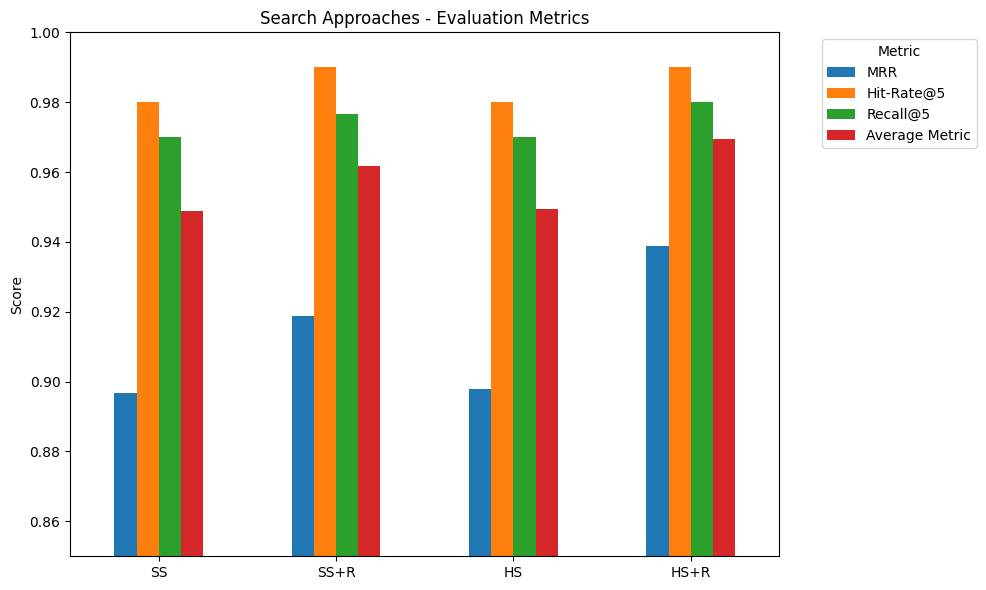

In [ ]:
# Convert dict to DataFrame
df = pd.DataFrame(final_results_per_approach).T

# Mapping for short codes
approach_codes = {
    "Semantic Search without reranking": "SS",
    "Semantic Search with reranking": "SS+R",
    "Hybrid Search without reranking": "HS",
    "Hybrid Search with reranking": "HS+R"
}

# Apply short codes as index
df_short = df.copy()
df_short.index = df_short.index.map(approach_codes)

# Plot metrics (excluding Avg Delay)
plt.figure(figsize=(10, 6))
ax = df_short.drop(columns="Avg Delay").plot(kind='bar', ax=plt.gca())
plt.title("Search Approaches - Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0.85, 1.0)
plt.xticks(rotation=0)
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


# 4. Module 3 🤖

## 4.1 Module Definition

In [ ]:
class Module3_ContactInfo(Module):
    def __init__(self, model_name=MODEL, contact_info_path:str=f"{STELLAR_path}/requirements/module_3/contact_info.txt",
                 prompt_path:str=f"{STELLAR_path}/requirements/module_3/initial_prompt.txt"):
        super().__init__(model_name)
        self.contact_info = self.load_txt_file(contact_info_path)
        self.prompt = self.load_txt_file(prompt_path)

    def ask_module(self, query:str):
        """
        Interacts with a user to answer questions based on a predefined context and a language model.

        This function prompts the user for a query, processes it using a predefined context template,
        and queries a language model for an answer. It handles follow-up questions if the model
        indicates ambiguity or the need for clarification.
        Args:
            query (str): The user's query.
        Returns:
            str: The final answer provided by the language model, or an appropriate message
                if the query cannot be answered.
            str: The updated chat history.
        """

        # Main execution
        prompt = self.prompt.format(context=self.contact_info, question=query)
        model_answer = self.ask_model(prompt, MODEL)

        return model_answer

## 4.2 Running Experiment

In [ ]:
# Loading test cases
with open (f"{STELLAR_path}/experiments/test_cases/module_3.json", "r") as f:
    test_cases = json.load(f)

module = Module3_ContactInfo()
# Running Experiment
for test_case in tqdm(test_cases, desc="Running Test Cases"):
    query = test_case["question"]
    test_case["predicted_answer"] = module.ask_module(query)


Running Test Cases:   0%|          | 0/50 [00:00<?, ?it/s]

## 4.3 Displaying Results

In [ ]:
# Display accuracy
accuracy = sum(1 for test_case in test_cases if test_case["correct_answer"] in test_case["predicted_answer"]) / len(test_cases)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display mistakes
mistakes = [(test_case["question"], test_case["correct_answer"], test_case["predicted_answer"]) for test_case in test_cases if test_case["correct_answer"] not in test_case["predicted_answer"]]
for question, correct_answer, predicted_answer in mistakes:
    print(f"Question: {question}")
    print(f"Correct Answer: {correct_answer}")
    print(f"Predicted Answer: {predicted_answer}")
    print()

Accuracy: 90.00%
Question: How do I call the Customer Service?
Correct Answer: 0800 727 9966
Predicted Answer: -1. What type of customer service are you looking for (e.g. Auto, Health, Life, Dental, Security, etc.)?

Question: What is the telephone number of the oral health service of another country?
Correct Answer: -2.
Predicted Answer: -1. You didn't specify which oral health service you are referring to (e.g. Dental Relationship Center, Dental Ombudsman). Could you please provide more information about the specific service you need to contact?

Question: What is the WhatsApp Pension number?
Correct Answer: (21) 4004-2702
Predicted Answer: -1. What type of pension are you referring to (Individual, Private, Corporate, or Pension Fund)?

Question: How to contact the Individual Social Security Relationship Center in the capitals?
Correct Answer: 4002 0022
Predicted Answer: -1. There is no information about the "Individual Social Security Relationship Center" in the context provided. Ho

# 5. Module 4 🤖

## 5.1 Module Definition

In [ ]:
class Module4_HumanEscalation(Module):
    def __init__(self, model_name=MODEL, insurance_weights_path:str=f"{STELLAR_path}/requirements/module_4/insurance_weights.json",
                 category_weights_path:str=f"{STELLAR_path}/requirements/module_4/category_weights.json",
                 name_and_ins_type_prompt_path:str=f"{STELLAR_path}/requirements/module_4/name_and_ins_type_prompt.txt",
                 sum_and_cat_prompt_path:str=f"{STELLAR_path}/requirements/module_4/sum_and_cat_prompt.txt",
                 recommended_message_prompt_path:str=f"{STELLAR_path}/requirements/module_4/recommended_message_prompt.txt",
                 waiting_list_path:str=f"{STELLAR_path}/outputs/module_4/waiting_list.json",
                 human_agents_path:str=f"{STELLAR_path}/human_agents/human_agents.json"):
        super().__init__(model_name)
        self.insurance_weights = self.load_json_file(insurance_weights_path)
        self.category_weights = self.load_json_file(category_weights_path)
        self.name_and_ins_type_prompt = self.load_txt_file(name_and_ins_type_prompt_path)
        self.sum_and_cat_prompt = self.load_txt_file(sum_and_cat_prompt_path)
        self.recommended_message_prompt = self.load_txt_file(recommended_message_prompt_path)
        self.waiting_list_path = waiting_list_path
        self.human_agents_path = human_agents_path

    def model_answer_name_and_ins_type(self, chat_history, model, max_retries=3):
        """
          Processes a chat_history through the model and returns the response as a dictionary.
          Retries once if the response is not valid JSON, and falls back to parsing_error_handler.
          Args:
              chat_history (str): The input chat_history.
              model (str): The model to query.

          Returns:
              dict: The response from the model as a dictionary in the format
              {"name": <str>, "insurance_type": <int>}.
        """
        attempt = 0
        while attempt < max_retries:
            try:
                prompt = self.name_and_ins_type_prompt + chat_history
                answer = self.ask_model(prompt, model)

                if not answer:
                    raise ValueError("Answer is None")

                return self.parse_str_to_json(answer, ["name", "insurance_type"])

            except Exception as e:
                print(f"Attempt {attempt + 1} failed in model_answer_name_and_ins_type: {e}")
                attempt += 1

        # if parsing failed, return the default name and ins_type
        output = {
            "name": "",
            "insurance_type": 0
        }
        return output

## 5.2 Running Experiment

In [ ]:
with open(f"{STELLAR_path}/experiments/test_cases/module_4.json", "r") as f:
    test_cases = json.load(f)

module = Module4_HumanEscalation()
for test_case in tqdm(test_cases, desc="Running Test Cases"):
    test_case["predicted_answer"] = module.model_answer_name_and_ins_type(test_case["chat_history"], MODEL)

Running Test Cases:   0%|          | 0/20 [00:00<?, ?it/s]

## 5.3 Displaying Results

In [ ]:
# Evaluating the name and insurance type recognition
correct_names = 0
correct_ins_types = 0
for test_case in test_cases:
    if test_case["correct_name"] == test_case["predicted_answer"]["name"]:
        correct_names += 1
    if test_case["correct_insurance_type"] == test_case["predicted_answer"]["insurance_type"]:
        correct_ins_types += 1
accuracy_names = correct_names / len(test_cases)
accuracy_ins_types = correct_ins_types / len(test_cases)

print(f"Accuracy for name recognition: {accuracy_names * 100:.2f}%")
print(f"Accuracy for insurance type recognition: {accuracy_ins_types * 100:.2f}%")

Accuracy for name recognition: 100.00%
Accuracy for insurance type recognition: 100.00%


# 6. Module 5 🤖

## 6.1 Module Definition

In [ ]:
class Module5_SentimentAnalysis(Module):
    def __init__(self, model_name:str=MODEL,
                 sentiment_model="cardiffnlp/twitter-roberta-base-sentiment-latest"):
        super().__init__(model_name)
        self.sentiment_model = sentiment_model

    def sentiment_analysis(self, text: str) -> dict[str, float]:
        """
        Analyzes the sentiment of a given text and returns sentiment scores.
        Args:
            text (str): Input text.
        Returns:
            dict[str, float]: Sentiment scores for positive, neutral, and negative classes.
        Example: {"positive": 0.03, "neutral": 0.92, "negative": 0.05}
        """

        # Define tokenizer, config and model
        tokenizer = AutoTokenizer.from_pretrained(self.sentiment_model)
        config = AutoConfig.from_pretrained(self.sentiment_model)
        model = AutoModelForSequenceClassification.from_pretrained(self.sentiment_model)

        # Tokenize input text
        encoded_input = tokenizer(text, return_tensors='pt')

        # Perform sentiment analysis
        output = model(**encoded_input)
        scores = softmax(output[0][0].detach().numpy())

        # Map scores to sentiment labels
        return {"positive": float(scores[2]), "neutral": float(scores[1]), "negative": float(scores[0])}

## 6.2 Running Experiment

In [ ]:
with open(f"{STELLAR_path}/experiments/test_cases/module_5.json", "r") as f:
    test_cases = json.load(f)

module = Module5_SentimentAnalysis()
for test_case in tqdm(test_cases, desc="Running Test Cases"):
    test_case["predicted_sentiment"] = module.sentiment_analysis(test_case["question"])

Running Test Cases:   0%|          | 0/50 [00:00<?, ?it/s]

## 6.3 Displaying Results

Accuracy: 96.00%


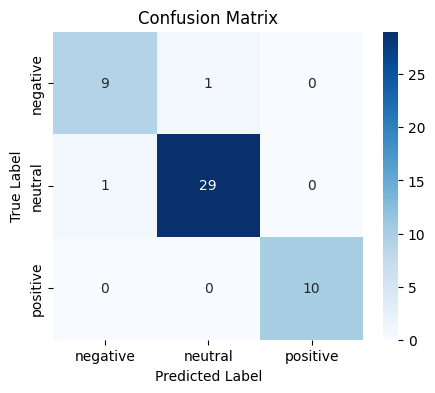


Misclassified questions:
ID: 7, Q: Doesn't your dental plan cover a treatment as simple as whitening?
Predicted: {'positive': 0.02546039968729019, 'neutral': 0.7262464761734009, 'negative': 0.24829310178756714}, Correct: negative

ID: 28, Q: What should I do if my car is stolen or has an accident?
Predicted: {'positive': 0.0099959010258317, 'neutral': 0.3962874114513397, 'negative': 0.5937166213989258}, Correct: neutral



In [ ]:
# Evaluation
y_true = [tc["correct_sentiment"] for tc in test_cases]
y_pred = [max(tc["predicted_sentiment"], key=tc["predicted_sentiment"].get) for tc in test_cases]

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.2%}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_true), yticklabels=set(y_true))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
# Show misclassified questions
print("\nMisclassified questions:")
for tc in test_cases:
    if max(tc["predicted_sentiment"], key=tc["predicted_sentiment"].get) != tc["correct_sentiment"]:
        print(f'ID: {tc["id"]}, Q: {tc["question"]}')
        print(f'Predicted: {tc["predicted_sentiment"]}, Correct: {tc["correct_sentiment"]}\n')

# 7. Module 6 🤖

## 7.1 Module Definition

In [ ]:
class Module6_FeedbackCollector(Module):
    def __init__(self, model_name:str=MODEL, requirements_path:str=f"{STELLAR_path}/requirements/module_6",
                 comments_path:str=f"{STELLAR_path}/outputs/module_6/comments"):
        super().__init__(model_name)
        self.requirements_path = requirements_path
        self.comments_path = comments_path

        # Load info from the requirements path
        self.category_to_team = self.load_json_file(f"{requirements_path}/category_to_team.json")
        self.categorization_prompt = self.load_txt_file(f"{requirements_path}/categorization_prompt.txt")
        self.feedback_questions = self.load_json_file(f"{requirements_path}/feedback_questions.json")
        self.keys = self.load_json_file(f"{requirements_path}/keys.json")
        self.feedback_categories = self.load_json_file(f"{requirements_path}/feedback_categories.json")


    def categorize_comment(self, customer_comment: str) -> list[str]:
        """
        Categorizes a customer comment into feedback categories.

        Args:
            customer_comment (str): The customer comment to categorize.

        Returns:
            List[str]: A list of feedback categories.
        """
        prompt = f"{self.categorization_prompt}\nInput: {customer_comment}\nOutput: "
        response = self.ask_model(prompt, self.model_name)
        categories = []
        for category in self.feedback_categories:
            if category in response:
                categories.append(category)

        if len(categories) > 0:
            return categories
        return ["Other"]


## 7.2 Running Experiments

In [ ]:
with open(f"{STELLAR_path}/experiments/test_cases/module_6.json", "r") as f:
    test_cases = json.load(f)

module = Module6_FeedbackCollector()
for test_case in tqdm(test_cases, desc="Running Test Cases"):
    test_case["predicted_categories"] = module.categorize_comment(test_case["chat_history"])

Running Test Cases:   0%|          | 0/50 [00:00<?, ?it/s]

## 7.3 Displaying Results

In [ ]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer

# Extract true and predicted labels
y_true = [set(tc["correct_categories"]) for tc in test_cases]
y_pred = [set(tc["predicted_categories"]) for tc in test_cases]

correct = 0
total = 0
for test_case in test_cases:
    for category in test_case["correct_categories"]:
        total += 1
        if category in test_case["predicted_categories"]:
            correct += 1

print(f"Accuracy: {correct / total:.2%}")

# Binarize the label sets
mlb = MultiLabelBinarizer()
Y_true = mlb.fit_transform(y_true)
Y_pred = mlb.transform(y_pred)

# Classification report
report = classification_report(Y_true, Y_pred, target_names=mlb.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report.style.background_gradient(cmap='Blues'))

Accuracy: 92.65%


,precision,recall,f1-score,support
Accessibility Issue,0.625000,1.000000,0.769231,5.000000
Agent Performance,0.833333,1.000000,0.909091,5.000000
Claims Processing Issue,0.666667,0.750000,0.705882,8.000000
Diverse Feedback,1.000000,0.333333,0.500000,3.000000
General Inquiry,0.428571,1.000000,0.600000,3.000000
Improvement Suggestion in Process,0.500000,1.000000,0.666667,4.000000
Insurance Policy Issue,0.500000,1.000000,0.666667,7.000000
Payment or Billing Issue,0.833333,1.000000,0.909091,5.000000
Positive Experience,0.800000,1.000000,0.888889,4.000000
Resource Request,1.000000,1.000000,1.000000,4.000000


# 8. Module 9 🤖

## 8.1 Module Definition

In [ ]:
class Module9_ComplianceVerifier(Module):
    def __init__(self, user_question:str, llm_response:str, model_name:str="gemma2-9b-it",
                 prompt_path:str=f"{STELLAR_path}/requirements/module_9/prompt_compliance_verifier_1.txt",
                 log_path:str=f"{STELLAR_path}/outputs/module_9/logs/violations.json"):
        super().__init__(model_name)
        self.user_question = user_question
        self.llm_response = llm_response
        self.prompt_path = prompt_path
        self.log_path = log_path
        self.prompt = self.load_prompt()

    def load_prompt(self):
        with open(self.prompt_path, "r") as f:
            prompt = f.read()
        return prompt

    def format_input(self) -> str:
        """
        Formats the input for the LLM by combining the chat history, LLM response, and the loaded prompt.
        Returns the formatted input string ready to be sent to the model.
        """
        dict_input = {"query":self.user_question, "response":self.llm_response}
        prompt = self.prompt + json.dumps(dict_input, indent=2, ensure_ascii=False)
        return prompt

    def parse_response(self, llm_output: str) -> dict:
        """
        Parses the output from the model and extracts a dict of fields "compliance"
        and "violation". If the answer is not in json format or the fields are
        not present, the function raises an exception.

        Args:
            llm_output (str): The output from the model as a string.

        Returns:
            dict: A dictionary containing the parsed fields.

        Raises:
            Exception: If the response is not in JSON format or the fields are missing.
        """
        try:
            if llm_output is None:
                raise Exception("LLM output is None.")
            dict_response = llm_output[llm_output.index("{"):llm_output.index("}")+1]
            json_data = json.loads(dict_response)
            if "compliance" not in json_data or "violation" not in json_data:
                raise Exception("Missing 'compliance' or 'violation' field in LLM response.")
            if not isinstance(json_data["compliance"], bool) or not isinstance(json_data["violation"], str):
                raise Exception("Invalid data type for 'compliance' or 'violation' field.")
            if not json_data["violation"].strip():
                raise Exception("Empty 'violation' field.")
            if len(json_data) != 2:
                raise Exception("LLM response has more than 2 fields.")
            return json_data
        except json.JSONDecodeError:
            print("Response: " + llm_output)
            raise Exception("LLM response is not in JSON format.")


    def run_verification(self) -> dict:
        """
        Executes the compliance verification process.
        Combines input formatting, sending the request to the model, and analyzing the response.
        Returns:
            dict: The final compliance analysis, including compliance status and violations in this format:
                {"compliance": <bool>, "violation": <str>}

        """
        input = self.format_input()
        llm_output = self.ask_model(input, self.model_name)
        for i in range(3):
            if llm_output is None:
                print(f"LLM output is None, retrying... ({i+1}/3)")
                continue
            try:
                results = self.parse_response(llm_output)
                return results
            except Exception as e:
                print(f"Error parsing response: {e}")

        return {"compliance": False, "violation": f"ERROR: unable to parse the LLM response: {llm_output}"}


## 8.2 Running Experiment

In [ ]:
with open(f"{STELLAR_path}/experiments/test_cases/module_9.json", "r") as f:
    test_cases = json.load(f)

for test_case in tqdm(test_cases, desc="Running Test Cases"):
    module = Module9_ComplianceVerifier(user_question=test_case["user_question"], llm_response=test_case["model_response"])
    test_case["compliance_analysis"] = module.run_verification()

Running Test Cases:   0%|          | 0/50 [00:00<?, ?it/s]

## 8.3 Displaying Results

Accuracy (compliance): 100.00%



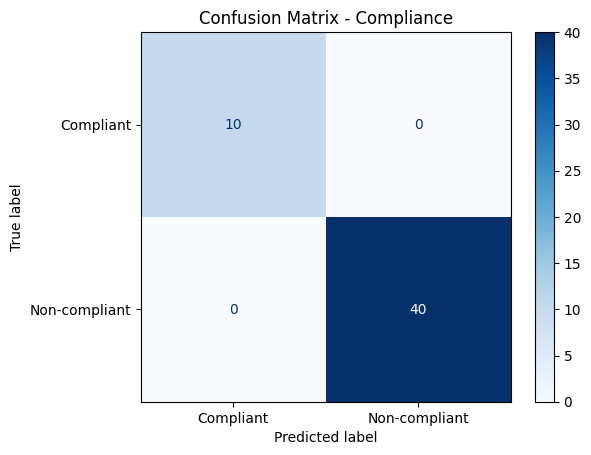

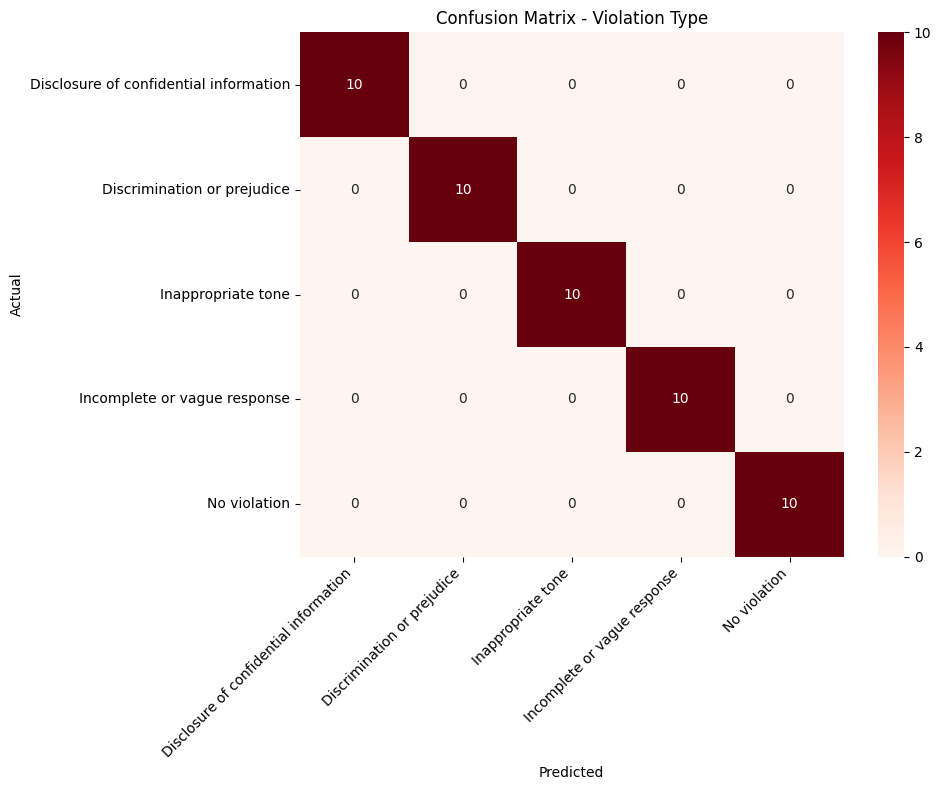

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

df = pd.DataFrame(test_cases)

# Extract ground truth and predictions for compliance
y_true_compliance = df["compliance"]
y_pred_compliance = df["compliance_analysis"].apply(lambda x: x["compliance"])

# Accuracy
accuracy = accuracy_score(y_true_compliance, y_pred_compliance)
print(f"Accuracy (compliance): {accuracy:.2%}\n")

# Confusion Matrix - Compliance
cm_compliance = confusion_matrix(y_true_compliance, y_pred_compliance, labels=[True, False])
disp1 = ConfusionMatrixDisplay(cm_compliance, display_labels=["Compliant", "Non-compliant"])
disp1.plot(cmap='Blues')
plt.title("Confusion Matrix - Compliance")
plt.show()

# Show all first-kind misclassifications (compliance mismatch)
misclassified = [tc for tc in test_cases if tc["compliance_analysis"]["compliance"] != tc["compliance"]]
for tc in misclassified:
    print(f"User Question: {tc['user_question']}")
    print(f"Model Response: {tc['model_response']}")
    print(f"True Compliance: {tc['compliance']}")
    print(f"Predicted Compliance: {tc['compliance_analysis']['compliance']}")

# Extract ground truth and predictions for violation
y_true_violation = df["violation"]
y_pred_violation = df["compliance_analysis"].apply(lambda x: x["violation"])

# Unique violation types
violation_labels = sorted(set(y_true_violation) | set(y_pred_violation))

# Confusion Matrix - Violation Type
cm_violation = confusion_matrix(y_true_violation, y_pred_violation, labels=violation_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_violation, annot=True, fmt='d', xticklabels=violation_labels, yticklabels=violation_labels, cmap="Reds")
plt.title("Confusion Matrix - Violation Type")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
misclassified = [tc for tc in test_cases if tc["compliance_analysis"]["violation"] != tc["violation"]]
for tc in misclassified:
    print(f"User Question: {tc['user_question']}")
    print(f"Model Response: {tc['model_response']}")
    print(f"True Compliance: {tc['compliance']}")
    print(f"Predicted Compliance: {tc['compliance_analysis']['compliance']}")
    print()